# Imports and plot parameters

In [1]:
!pip install statannot

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import isnan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.formula.api import ols
from itertools import chain
from matplotlib.pyplot import figure
from statannot import add_stat_annotation
from scipy.stats import levene

# Plot params
plt.style.use('seaborn');
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 300
sns.set_context("talk")
figure(figsize=(8, 6), dpi=300);
sns.set_style("whitegrid")
sns.set_palette("tab10")

<Figure size 2400x1800 with 0 Axes>

# Helper Functions

Functions just for cleaning up the messes I've made during data collection and elsewhere

In [2]:
def remove_failed_comprehension_checks(df):
    '''
    Remove participants that do not pass comprehension check
    in at most 3 tries
    '''
    limit = 3
    num_asks = 3
    threshold = limit*num_asks
    group = df.groupby(["subject_id"])
    subjs = list(group.attempts.count()[group.attempts.count() > threshold].index)
    return df[~df["subject_id"].isin(subjs)]

def drop_columns(df):
    '''
    Drop unused columns
    '''
    return df.drop(columns=["failed_video","failed_audio","failed_images",
                           "internal_node_id","timeout", "stimulus",
                            "study_id","session_id","success","attempts",
                           "trial_type","time_elapsed", "value"])

def adjust_trial_index(df):
    '''
    Reindex the 48 trial indices from [21-N] to [0-N]
    '''
    indices = list(range(48))
    df['trial_index'] = indices
    return df

def compare(item1):
    '''
    Comparator for sorting scenes
    '''
    if item1[0] == 'l':
        return -1
    elif item1[0] == 'm':
        return 0
    else:
        return 1
    
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

# Read in data and organize dataframes

Dataframes:
- **data**: containing raw empirical data
- **responses**: containing cleaned empirical data 
- **clean_responses**: containing cleaned empirical data with outlier values removed (using 2sd method)

## Raw data

In [5]:
# Paths to data
data_path = "../experiments/experiment3/data/data.csv"
model_path = "../data/model/pilot3/simulation_vals.json"

In [9]:
# Read in data
data = pd.read_csv(data_path)
# Making sure the condition and responses are the same
data.condition = data.condition.apply(lambda x: x.lower())

## Cleaned data

### Organizing columns and indices

In [13]:
# Dataframe containing only the trial responses
responses = data[data.task == 'response']
# Dropping columns
responses = drop_columns(responses)
# Reset index
responses = responses.reset_index(drop=True)
# Rename columns
responses = responses.rename(columns={'condition':'exp_condition',
                                     'response': 'response_'})
# Reindexing the trial indices
responses = responses.groupby('subject_id').apply(adjust_trial_index)

### Reindexing scenes

In [14]:
# Gather scenes
scenes = list(responses.scene.unique())
# Sort them according to our comparison function
scenes.sort(reverse=False,key=compare)
# Create new index
index = list(range(len(scenes)))
# Create mapping from scenes to index
scene_index_map = {s:i for s,i in zip(scenes,index)}
# Create index in response dataframe
responses.scene_index = responses.scene.apply(lambda x: scene_index_map[x])

### Recoding dataframe values for analyses

In [7]:
# Z-Score RT
responses['zrt'] = (responses['rt'] - responses['rt'].mean())/responses['rt'].std(ddof=0)

# Taking the log(RT) and adding to dataframe
responses["log_rt"] = responses.rt.apply(lambda x: np.log(x))

# Z-score log RT
responses['zlogrt'] = (responses['log_rt'] - responses['log_rt'].mean())/responses['log_rt'].std(ddof=0)

# Adding per-trial condition (i.e. was the correct answer yes or no)
responses['trial_condition'] = responses.correct_response == responses.exp_condition
responses['trial_condition'] = responses.trial_condition.apply(lambda x: "Yes" if x else "No")

# Recoding the responses as "yes" or "no" instead of condition-dependent key
responses['response'] = responses.exp_condition == responses.response_
responses['response'] = responses.response.apply(lambda x: "Yes" if x else "No")

# Adding per-participant accuracy to the dataframe
responses['participant_accuracy'] = responses.groupby('subject_id')['correct'].transform('sum')/len(responses.groupby('trial_index'))
responses['trial_accuracy'] = responses.groupby('trial_index')['correct'].transform('sum')/len(responses.groupby('subject_id'))
responses['scene_accuracy'] = responses.groupby('scene')['correct'].transform('sum')/len(responses.groupby('subject_id'))

# Split scene conditions into simulation time and collision-no-collision
responses = pd.concat([responses, responses.scene.str.split("_", expand=True)],axis=1)
responses = responses.rename(columns={0:'sim_time',
                                      1: 'collision',
                                      2: 'straight_path'})
responses['collision'] = responses['collision'].str.replace('\d+', '')

/var/folders/6l/1kj5v3gx7r3264z3jy47_43c0000gn/T/ipykernel_13058/3270390208.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  responses['collision'] = responses['collision'].str.replace('\d+', '')


### Removing outliers

#### Timed-out

In [8]:
# Limiting response times to the timout max
responses.rt = responses.rt.apply(lambda x: 5000 if pd.isna(x) else x)
responses.rt = responses.rt.apply(lambda x: 5000 if x > 5000 else x)

#### Outlier responses

We use the +-2sd method *(Berger A., Kiefer M., Comparison of Different Response Time Outlier Exclusion Methods: A Simulation Study, 2021)*

In [9]:
clean_responses = responses[abs(responses.zrt) <= 2]
clean_responses['scene'] = clean_responses.scene.apply(lambda x: x.split('.')[0])

/var/folders/6l/1kj5v3gx7r3264z3jy47_43c0000gn/T/ipykernel_13058/82139672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_responses['scene'] = clean_responses.scene.apply(lambda x: x.split('.')[0])


### Save data

Save data to directory

In [3]:
# dir = "../experiments/experiment3/data/cleaned_data.json"
# data_json = clean_responses.to_json(dir)
datadir = "../experiments/experiment3/data/cleaned_data.json"
# Read empirical data into dataframe
clean_responses = pd.read_json(datadir)

# Plots

## Accuracy Per Collision Condition
Did accuracy change according to whether the ball was going to collide with the goal or not?

**Conclusions**
1. Accuracy is not normally-distributed for either collision condition (Shapiro, p < 8e-43)
2. Accuracy for No-Collision condition is significantly less than for Yes-Collision condition (MWU, p = 0.005)

### BoxPlot: Accuracy per collision condition

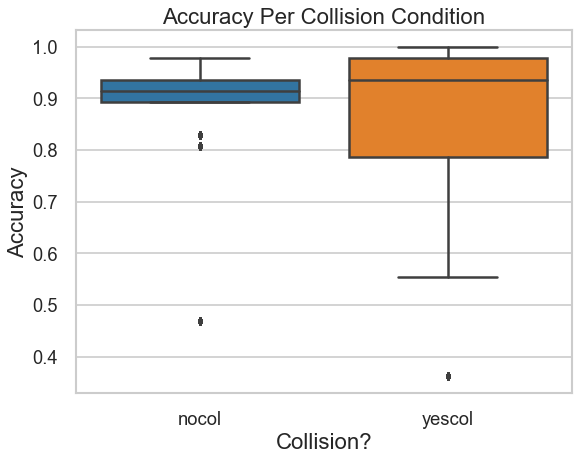

In [18]:
trial=clean_responses.groupby("trial_condition").scene_accuracy.apply(list)
sns.boxplot(y="scene_accuracy",x="collision",data=clean_responses)
plt.title("Accuracy Per Collision Condition",fontsize=20)
plt.xlabel("Collision?",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.show()

### Statistical Tests: Shapiro & One-sided MWU

In [5]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

no = list(clean_responses[(clean_responses["collision"]=="nocol")].scene_accuracy)
yes = list(clean_responses[(clean_responses["collision"]=="yescol")].scene_accuracy)

shap_yes = shapiro(yes)
shap_no = shapiro(no)

print(f"Shapiro Test Results:")
print(f"\tCollision condition data is: {'not' if shap_yes.pvalue < 0.05 else ''} normal with p-val = {shap_yes.pvalue}.")
print(f"\tNo-collision condition data is: {'not' if shap_no.pvalue < 0.05 else ''} normal with p-val = {shap_no.pvalue}.")
print("")

u_res = mannwhitneyu(no, yes, alternative="less")
print(f"MWU Results:")
print(f"\tNo-collision accuracy is {'' if u_res.pvalue < 0.05 else 'not'} significantly less than Collision condition with p-val = {u_res.pvalue}")

Shapiro Test Results:
	Collision condition data is: not normal with p-val = 4.06035447487944e-34.
	No-collision condition data is: not normal with p-val = 1.401298464324817e-45.

MWU Results:
	No-collision accuracy is  significantly less than Collision condition with p-val = 0.00539923662368249


## Accuracy Per Simulation-Time Condition
Did accuracy change according to simulation time?

**Conclusions**
1. Accuracy is not normally distributed across simulation-time conditions (Shapiro, p < 2e-28)
2. Accuracy is significantly different between Low and Med condition (MWU, p=5.5e-28)
3. Accuracy is significantly different between Med and High condition (MWU, p=3.9e-15)
4. Accuracy is not significantly different between Low and High condition (MWU, p=0.31)

### BoxPlot: Accuracy per simulation-time condition

Text(0, 0.5, 'Accuracy')

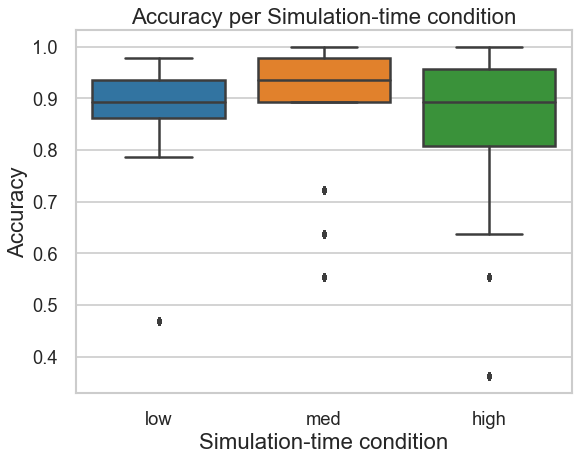

In [6]:
custom_dict = {'low':0, 'med':1,'high':2}
trial=pd.DataFrame(clean_responses.groupby("sim_time").scene_accuracy.apply(list))
trial = trial.sort_values(by=['sim_time'],key=lambda x: x.map(custom_dict))

sns.boxplot(x="sim_time", y="scene_accuracy",data=clean_responses,order=['low','med','high'])
plt.title("Accuracy per Simulation-time condition",fontsize=20)
plt.xlabel("Simulation-time condition",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)

### Stats: Shapiro & One-sided MWU

In [7]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].scene_accuracy)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].scene_accuracy)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].scene_accuracy)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: Data is {'not' if shap_low.pvalue < 0.05 else ''} normal with p-val={shap_low.pvalue}")
print(f"Med Shapiro: Data is {'not' if shap_med.pvalue < 0.05 else ''} normal with p-val={shap_med.pvalue}")
print(f"High Shapiro: Data is {'not' if shap_high.pvalue < 0.05 else ''} normal with p-val={shap_high.pvalue}")
print("")

u_res = mannwhitneyu(low, med, alternative="two-sided")
u_res_mh = mannwhitneyu(med, high, alternative="two-sided")
u_res_lh = mannwhitneyu(low, high, alternative="two-sided")

print(f"Low-Med T test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: Data is not normal with p-val=1.155456791717337e-37
Med Shapiro: Data is not normal with p-val=9.134411196869865e-34
High Shapiro: Data is not normal with p-val=3.440484261918896e-29

Low-Med T test statistic: MannwhitneyuResult(statistic=181503.5, pvalue=5.575714337686586e-28)
Med-High U test statistic: MannwhitneyuResult(statistic=320807.0, pvalue=3.885187145941786e-15)
Low-High U test statistic: MannwhitneyuResult(statistic=273288.0, pvalue=0.31327757303788817)


In [8]:
high_no = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "nocol")].scene_accuracy)
high_yes = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "yescol")].scene_accuracy)

u_res = mannwhitneyu(high_yes, high_no, alternative="less")

print(f"High-Yes High-No U test statistic: {u_res}")

High-Yes High-No U test statistic: MannwhitneyuResult(statistic=67649.0, pvalue=0.9245627287617038)


## RT Per Simulation-Time Condition
Did RT change according to simulation time?

### Boxplot: RT per simulation-time condition

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

low v.s. med: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.939e-34 U_stat=1.701e+05
med v.s. high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.066e-07 U_stat=2.184e+05
low v.s. high: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.719e-69 U_stat=1.233e+05


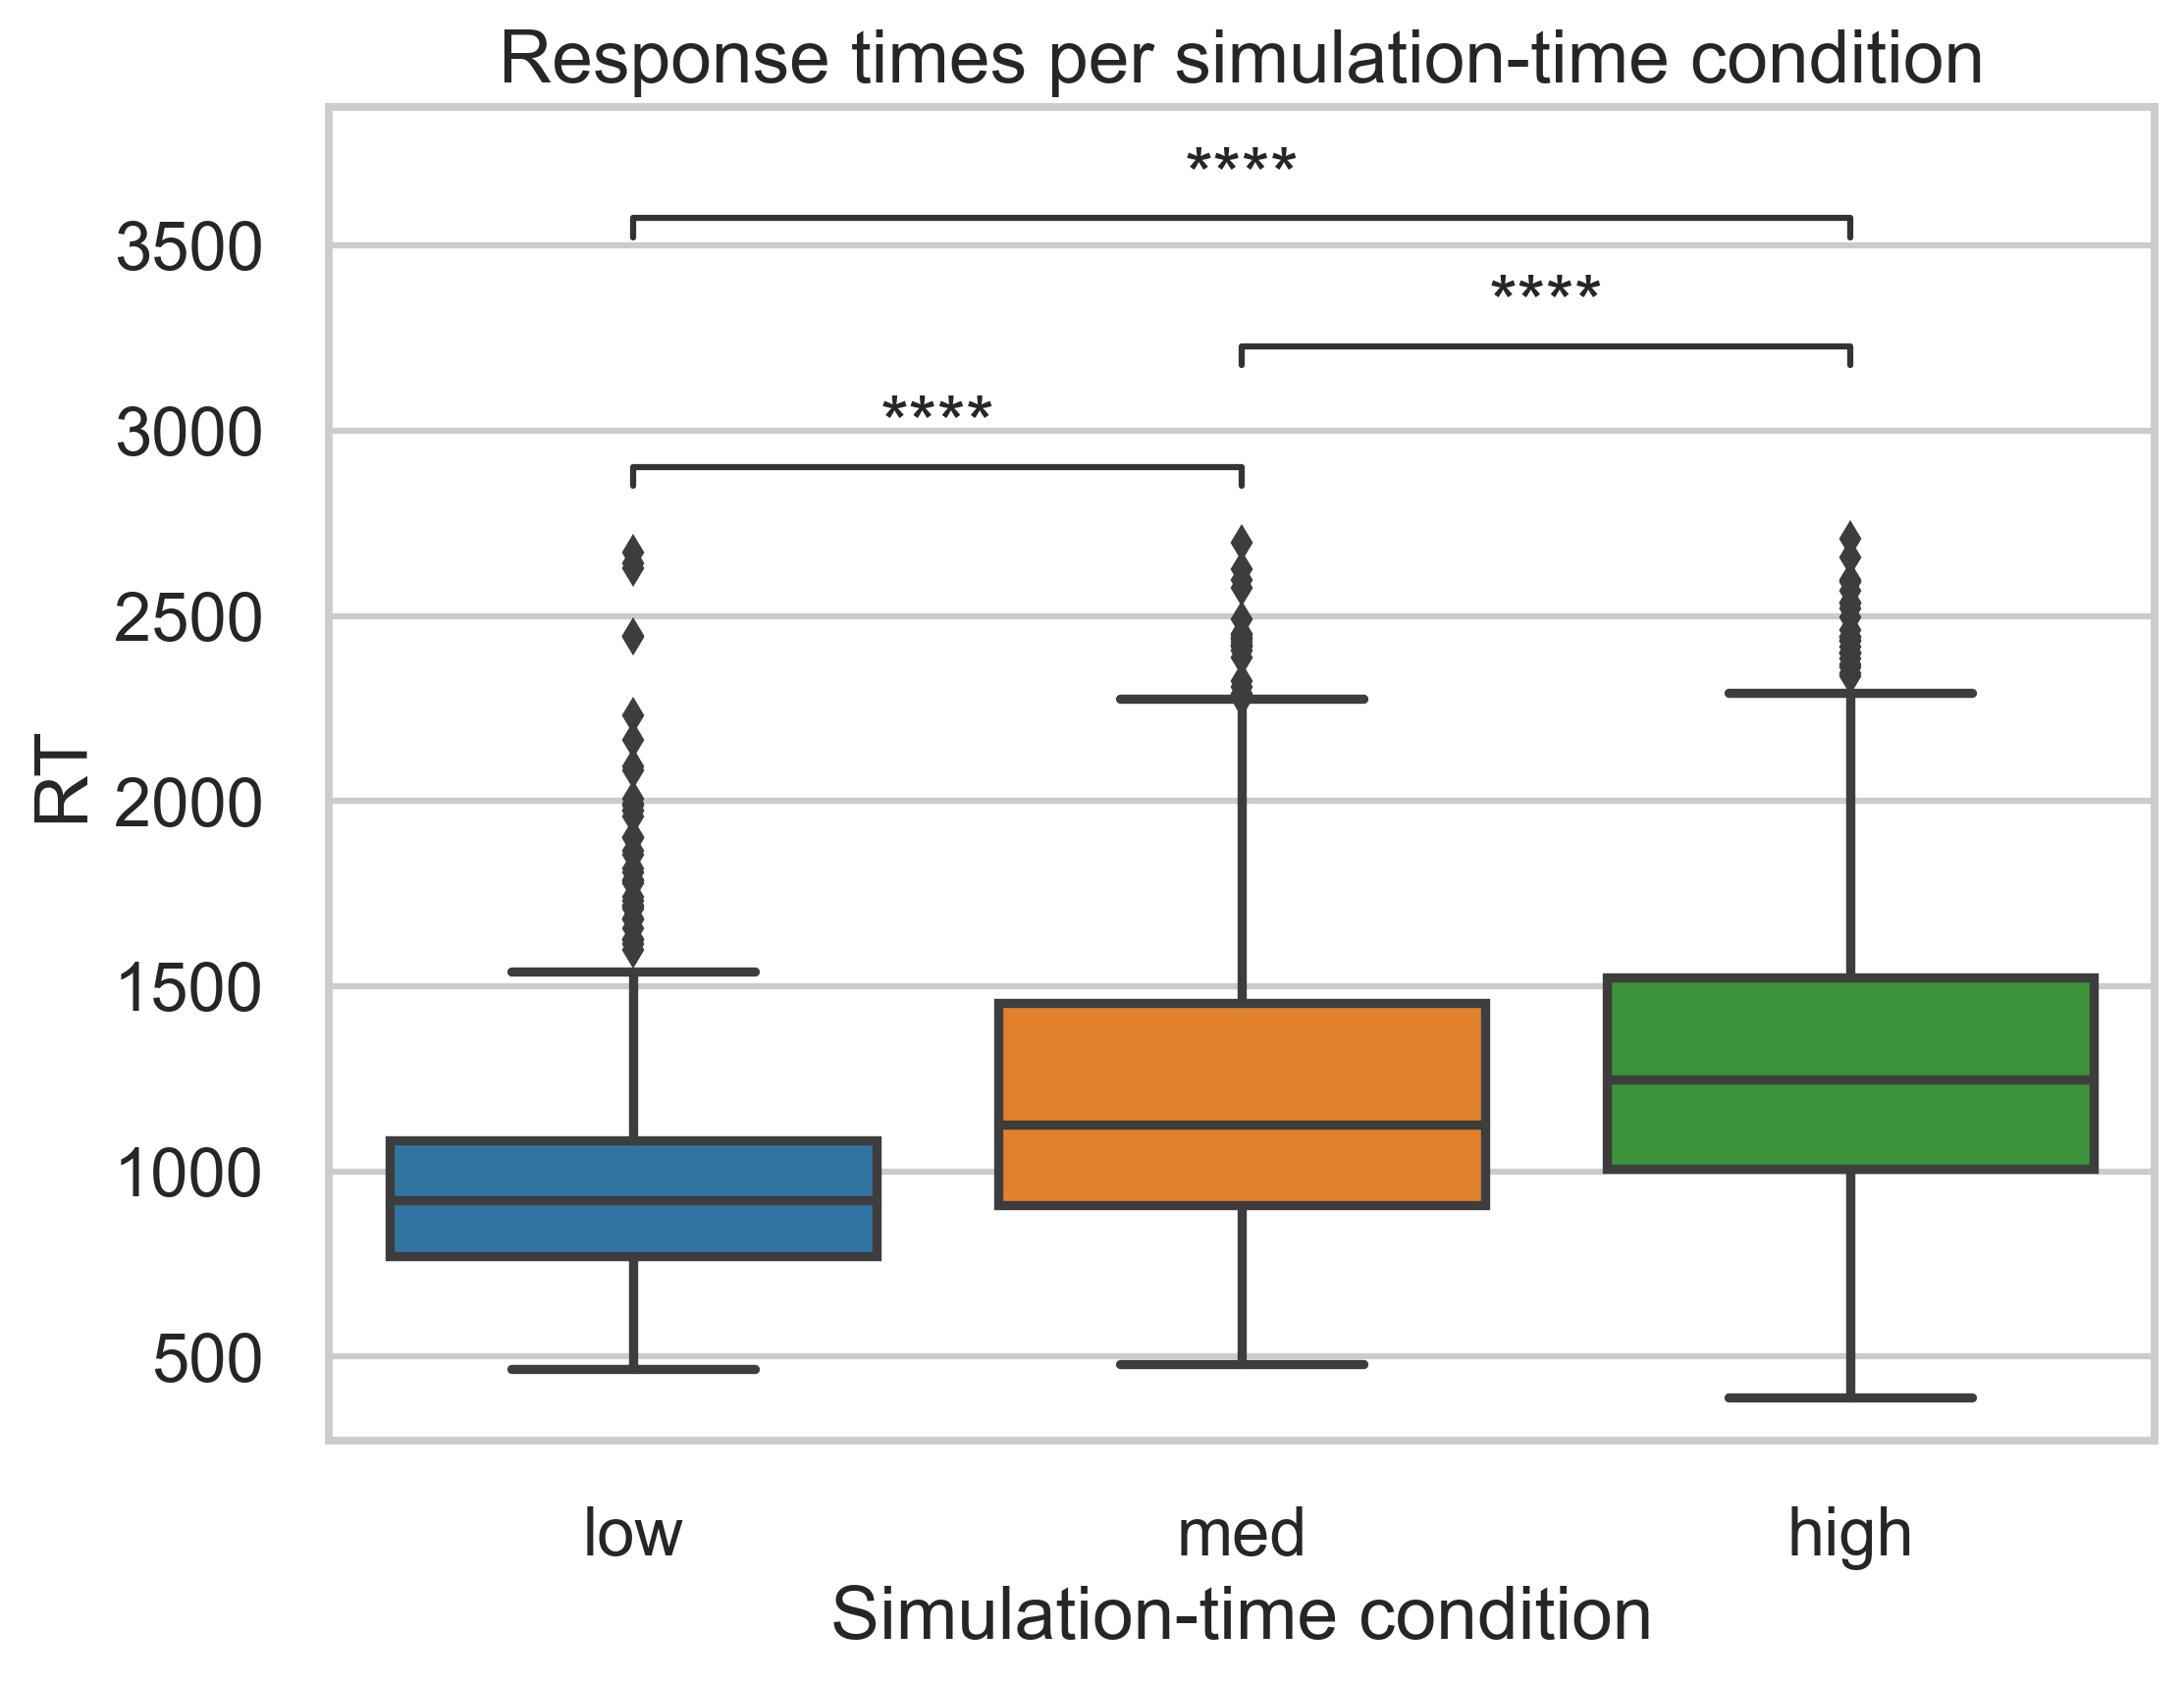

In [20]:
df = clean_responses
x = "sim_time"
y = "rt"
order = ['low','med','high']
ax = sns.boxplot(data=df, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                   box_pairs=[("low", "med"), ("med", "high"), ("low", "high")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
plt.title("Response times per simulation-time condition")
plt.ylabel("RT")
plt.xlabel("Simulation-time condition")
test_results;

In [25]:
clean_responses.groupby('sim_time').rt.describe()

,count,mean,std,min,25%,50%,75%,max
sim_time,,,,,,,,
high,714.0,1318.002801,409.896925,390.0,1007.00,1248.0,1522.75,2708.0
low,743.0,982.707941,310.484574,467.0,772.50,922.0,1084.50,2672.0
med,726.0,1222.597796,419.862376,480.0,908.75,1127.5,1455.75,2697.0


### Histogram: RT per simulation-time condition

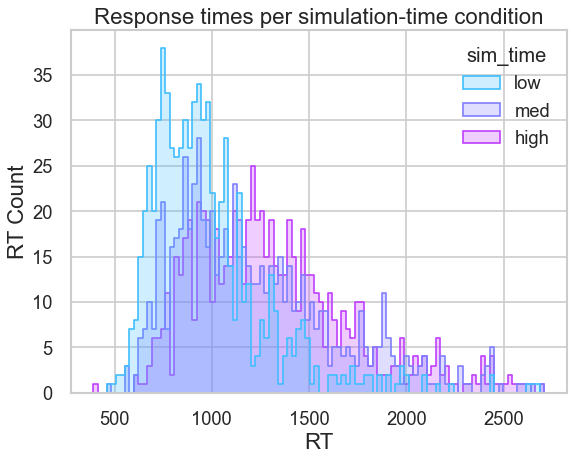

In [16]:
sns.histplot(x="rt", data=clean_responses, bins=100,hue="sim_time",element="step",palette="cool");
plt.title("Response times per simulation-time condition",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("RT Count",fontsize=20);

### Statistical Tests for Difference (Mann-Whitney U Test and Shapiro Test)
Determining whether RT is normally distributed and whether there is difference across the RT according to simulation time condition

#### Conclusions:
RT is not normally distributed in any grouping according to simulation time (p < 3e-23)

There exists statistical differences (Mann-Whitney U) between each grouping of RT: 
- **Low < Med** p = 5e-35
- **Med < High** p = 2e-07
- **Low < High** p = 5e-70

In [17]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].rt)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].rt)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].rt)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: {shap_low}. Data is {'not' if shap_low.pvalue < 0.05 else ''} normal.")
print(f"Med Shapiro: {shap_med}. Data is {'not' if shap_med.pvalue < 0.05 else ''} normal.")
print(f"High Shapiro: {shap_high}. Data is {'not' if shap_high.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(low, med, alternative="less")
u_res_mh = mannwhitneyu(med, high, alternative="less")
u_res_lh = mannwhitneyu(low, high, alternative="less")

print(f"Low-Med U test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: ShapiroResult(statistic=0.8545916676521301, pvalue=1.3582051165676233e-25). Data is not normal.
Med Shapiro: ShapiroResult(statistic=0.9319862127304077, pvalue=1.1954637551381745e-17). Data is not normal.
High Shapiro: ShapiroResult(statistic=0.9463719129562378, pvalue=2.08352020871134e-15). Data is not normal.

Low-Med U test statistic: MannwhitneyuResult(statistic=170116.5, pvalue=8.231265495166915e-35)
Med-High U test statistic: MannwhitneyuResult(statistic=218401.0, pvalue=1.1776700926713105e-07)
Low-High U test statistic: MannwhitneyuResult(statistic=123288.5, pvalue=2.8655886533698602e-70)


## RT Per Path Condition

Is RT affected by whether the scene is a straight-path or not?

**Conclusions**:
RT is not normally distributed in either grouping according to straight paths or not (p < 6.8e-17)

There exists statistical differences (Mann-Whitney U) between each SP and No SP, and each grouping of simulation time with SP and NoSP: 
- **SP < NoSP** p = 5e-57

Across Simulation Times, Across SP/NoSP:
- **LowSP < LowNoSP** p = 2e-07
- **MedSP < MedNoSP** p = 8e-33
- **HighSP < HighNoSP** p = 8.6e-23]

Across Simulation Times, Within SP:
- **LowSP < MedSP** p = 3e-16
- **MedSP < HighSP** p = 5e-10
- **LowSP < HighSP** p = 1.6e-42]

Across Simulation Times, Within NoSP:
- **LowNoSP < MedNoSP** p = 1e-29
- **MedNoSP < HighNoSP** p = 0.029
- **LowNoSP < HighNoSP** p = 2.8e-40]

### Boxplot: RT per path condition

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yessp v.s. nosp: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.438e-59 U_stat=3.571e+05


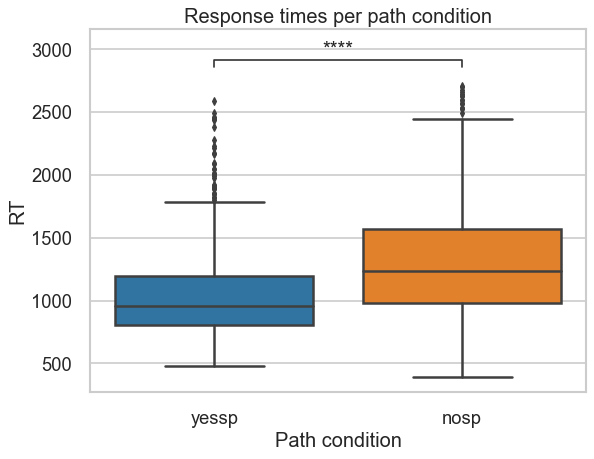

In [26]:
df = clean_responses
x = "straight_path"
y = "rt"
order = ['yessp','nosp']
ax = sns.boxplot(data=df, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                   box_pairs=[("yessp", "nosp")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)
plt.title("Response times per path condition")
plt.ylabel("RT")
plt.xlabel("Path condition")
test_results;

In [27]:
clean_responses.groupby('straight_path').rt.describe()

,count,mean,std,min,25%,50%,75%,max
straight_path,,,,,,,,
nosp,1073.0,1313.560112,440.199703,390.0,977.0,1236.0,1570.0,2708.0
yessp,1110.0,1035.461261,319.079065,480.0,809.0,959.0,1199.0,2591.0


### Histogram: RT per path condition

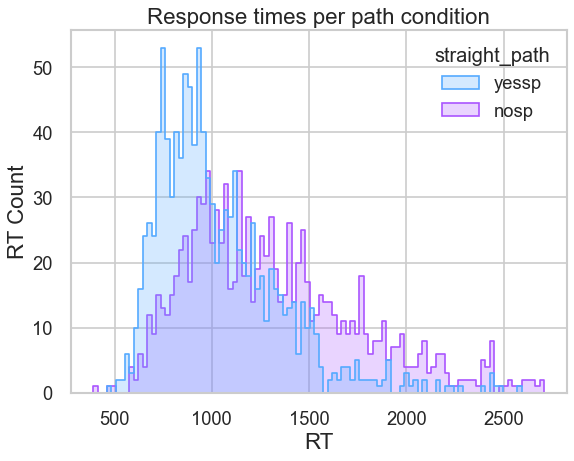

In [19]:
sns.histplot(x="rt", data=clean_responses, bins=100,hue="straight_path",element="step",palette="cool");
plt.title("Response times per path condition",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("RT Count",fontsize=20);

## RT Bootstrapped 95% CI

### Setting up dataframe containing bootstrapped distributions

In [102]:
# Bootstrap RT distribution according to simulation-time condition
simtime_bs_df = clean_responses.groupby('sim_time').rt.apply(lambda x: draw_bs_replicates(x,np.mean,1000))
simtime_bs_df = simtime_bs_df.to_frame()
simtime_bs_df = simtime_bs_df.reset_index()
simtime_bs_df = simtime_bs_df.explode('rt')
simtime_bs_df = simtime_bs_df.reset_index(drop=True)

In [103]:
# Bootstrap RT distribution according to path condition
path_bs_df = clean_responses.groupby('scene_sp').rt.apply(lambda x: draw_bs_replicates(x,np.mean,1000))
path_bs_df = path_bs_df.to_frame()
path_bs_df = path_bs_df.reset_index()
path_bs_df = path_bs_df.explode('rt')
path_bs_df = path_bs_df.reset_index(drop=True)

In [112]:
# Bootstrap RT distribution according to path and simulation-time conditions
st_path_bs_df = clean_responses.groupby(['sim_time','scene_sp']).rt.apply(lambda x: draw_bs_replicates(x,np.mean,1000))
st_path_bs_df = st_path_bs_df.to_frame()
st_path_bs_df = st_path_bs_df.reset_index()
st_path_bs_df = st_path_bs_df.explode('rt')
st_path_bs_df = st_path_bs_df.reset_index(drop=True)

### Histogram: BS 95% RT per simulation-time condition

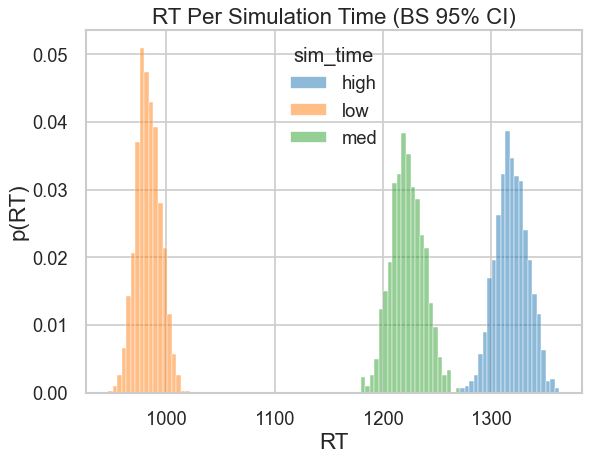

In [108]:
sns.histplot(x="rt",data=simtime_bs_df,hue='sim_time',stat="probability",bins=100,palette="tab10")
plt.title("RT Per Simulation Time (BS 95% CI)",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

### Histogram: BS 95% RT per path condition

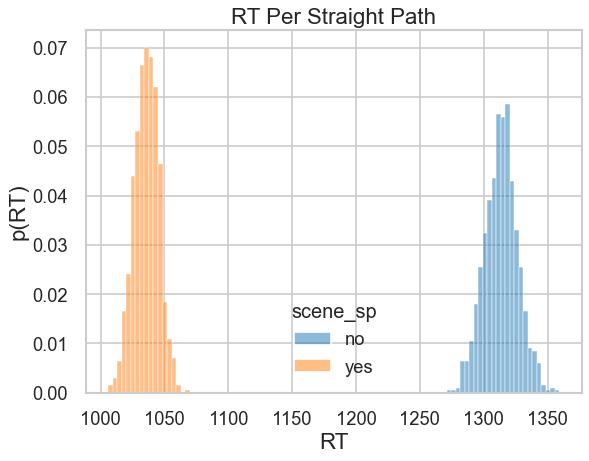

In [105]:
sns.histplot(x="rt",data=path_bs_df,hue='scene_sp',stat="probability",bins=100,palette="tab10")
plt.title("RT Per Straight Path",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

### Histogram: BS 95% per path X simulation-time conditions

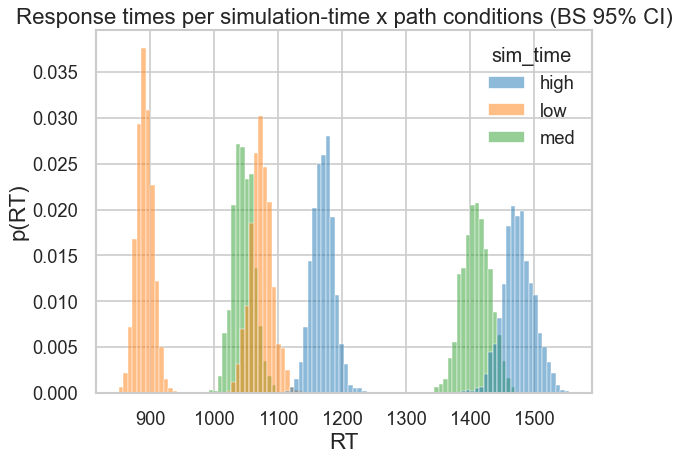

In [114]:
sns.histplot(x="rt",data=st_path_bs_df,hue=st_path_bs_df['sim_time'],stat="probability",bins=100,palette="tab10")
plt.title("Response times per simulation-time x path conditions (BS 95% CI)",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

# Modeling

### Read in model outputs

Dataframes:
- **sim_vals**: Ground-truth simulation runtime values

In [14]:
# Model Values
clean_responses = pd.read_json("../experiments/experiment3/data/cleaned_data.json")
split = pd.DataFrame()
models = pd.read_json("../data/model/pilot3/models.json")
for m in ['abstraction_pp_fit']:
    split = pd.concat([split, pd.DataFrame(models[m].tolist(),columns=[f'{m}_collision_prob',
                                                                       f'{m}_samples',
                                                                       f'{m}_ticks'])],axis=1)
models = pd.concat([models['name'], split],axis=1)
models = models.rename(columns={'name':'scene'});

In [15]:
# Simulation Values
sim_vals = pd.read_json("../data/model/pilot3/simulation_vals.json")#,converters=conv)
sim_vals = sim_vals.rename(columns={'name':'scene'})
sim_vals = sim_vals[['scene','ticks']]
sim_vals['tick_mean'] = sim_vals.ticks.apply(lambda x: np.mean(x))
sim_vals['tick_std'] = sim_vals.ticks.apply(lambda x: np.std(x))
clean_responses = clean_responses.merge(sim_vals, on='scene')

In [16]:
# Compute stats over ticks
for m in ['abstraction_pp_fit']:
    models[f'{m}_tick_mean'] = models[f'{m}_ticks'].apply(np.mean)

In [17]:
clean_responses = clean_responses.merge(models, on='scene')

#### Adding empirical RT averages to dataframe

In [18]:
df = clean_responses.groupby('scene').rt.apply(np.mean)
clean_responses['avg_rt'] = np.nan
for avg_rt,scene in zip(df,df.index):
    clean_responses.loc[clean_responses['scene']==scene,'avg_rt'] = avg_rt

### Plots

#### Response time vs simulation time per scene

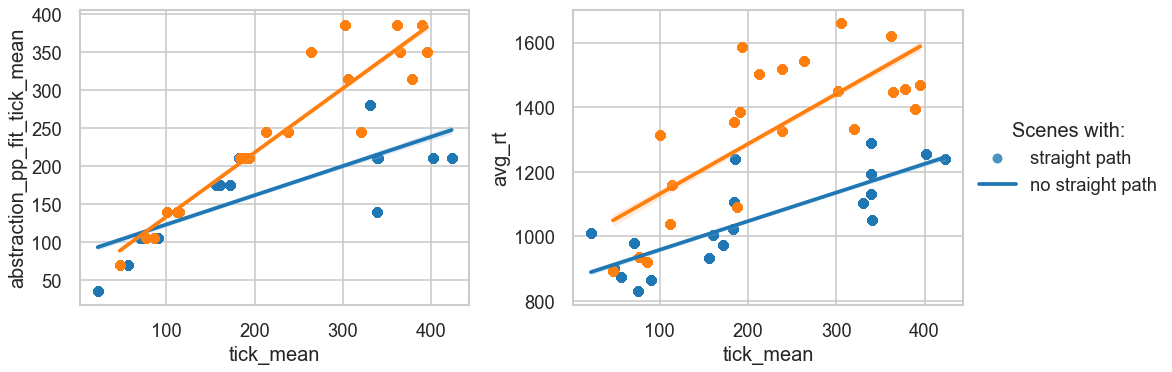

In [19]:
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
sns.regplot(x='tick_mean',y='abstraction_pp_fit_tick_mean', data=clean_responses[clean_responses.straight_path == 'yessp'], label="Straight path",ax=axs[0])
sns.regplot(x='tick_mean',y='avg_rt', data=clean_responses[clean_responses.straight_path == 'yessp'], label="Straight path",ax=axs[1])
sns.regplot(x='tick_mean',y='abstraction_pp_fit_tick_mean', data=clean_responses[clean_responses.straight_path == 'nosp'],label="No straight path", ax=axs[0])
sns.regplot(x='tick_mean',y='avg_rt', data=clean_responses[clean_responses.straight_path == 'nosp'],label="No straight path", ax=axs[1])
plt.legend(labels=["straight path","no straight path"], 
           title="Scenes with:", 
           loc='center left', 
           bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

#### Linear model for path conditions

In [25]:
formula = 'rt ~ abstraction_pp_tick_mean'

# Ordinary linear models based on path condition
model_sp = ols(formula, clean_responses[clean_responses.straight_path == 'yessp']).fit()
model_nosp = ols(formula, clean_responses[clean_responses.straight_path == 'nosp']).fit()

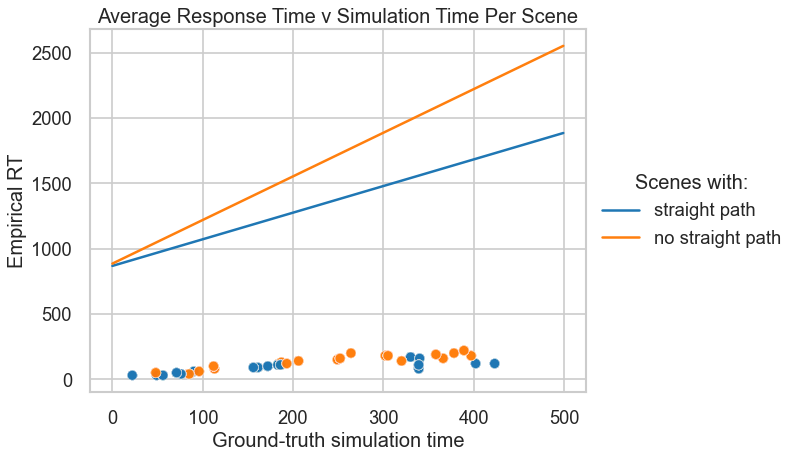

In [27]:
# Parameters from both models
p = model_sp.params
q = model_nosp.params

# x-values for regression lines
x = np.arange(0, 500)

# Scatterplot
ax = sns.scatterplot(x='deterministic_tick_mean', y='abstraction_pp_tick_mean', hue='straight_path',data=clean_responses,alpha= 0.1)

# Plot regression lines on the same axis object
ax.plot(x, p.Intercept + p.abstraction_pp_tick_mean * x)
ax.plot(x, q.Intercept + q.abstraction_pp_tick_mean * x)

plt.title("Average Response Time v Simulation Time Per Scene")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");
plt.legend(labels=["straight path","no straight path"], 
           title="Scenes with:", 
           loc='center left', 
           bbox_to_anchor=(1, 0.5))

# Leave

In [28]:
print(levene(model_sp.resid, model_nosp.resid))

LeveneResult(statistic=55.66145744166211, pvalue=1.3155596104363727e-13)


In [29]:
formula = 'rt ~ tick_mean + straight_path + tick_mean*straight_path' ## define the linear model using the formula api
result = ols(formula, clean_responses).fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     183.4
Date:                Thu, 27 Jan 2022   Prob (F-statistic):          4.16e-104
Time:                        14:00:48   Log-Likelihood:                -13600.
No. Observations:                1857   AIC:                         2.721e+04
Df Residuals:                    1853   BIC:                         2.723e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          976.4068     27.109     36.018      0.000     923.239    1029.574
straight_path[T.yessp]            -106.6775     35.903     -2.971      0.003    -177.092     -36.263
tick_mean                            1.5491      0.108     14.367      0.000       1.338       1.761
tick_mean:straight_path[T.yessp]    -0.6621      0.145     -4.558      0.000      -0.947      -0.377
==============================================================================
Omnibus:                      298.777   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              521.709
Skew:                           1.024   Prob(JB):                    5.16e-114
Kurtosis:                       4.597   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
hypotheses = '(straight_path[T.yessp]=0), (tick_mean:straight_path[T.yessp]=0)'
# A = np.identity(len(result.params))
f_test = result.f_test(hypotheses)
print(f_test)

<F test: F=array([[117.21187304]]), p=1.1677152135910962e-48, df_denom=1.85e+03, df_num=2>


#### RT per scene within simulation-time conditions

#### RT per scene within simulation-time conditions

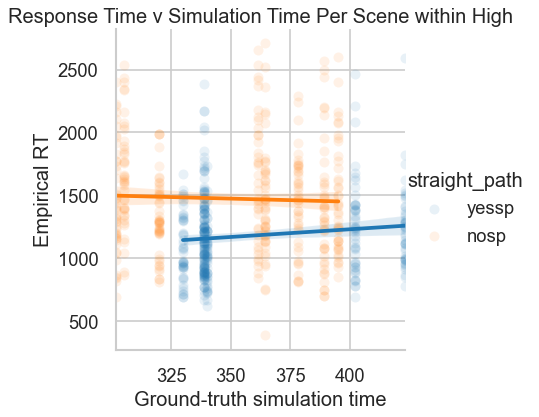

In [181]:
df = clean_responses[clean_responses.sim_time == "high"]
lm= sns.lmplot(x='tick_mean',y='rt',data=df,hue='straight_path',scatter=True,scatter_kws={"alpha": 0.1})
plt.title("Response Time v Simulation Time Per Scene within High")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");

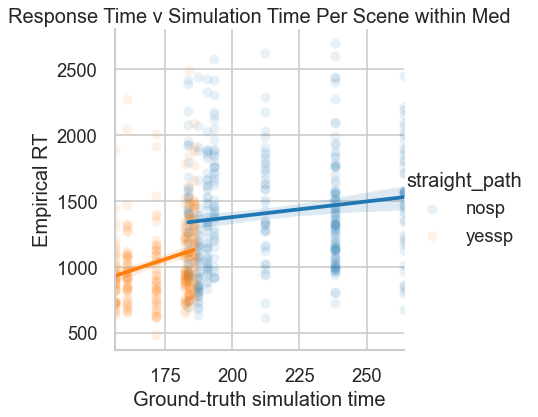

In [182]:
df = clean_responses[clean_responses.sim_time == "med"]
lm= sns.lmplot(x='tick_mean',y='rt',data=df,hue='straight_path',scatter=True,scatter_kws={"alpha": 0.1})
plt.title("Response Time v Simulation Time Per Scene within Med")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");

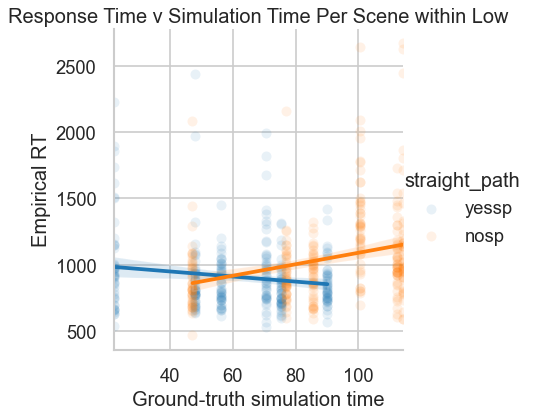

In [183]:
df = clean_responses[clean_responses.sim_time == "low"]
lm= sns.lmplot(x='tick_mean',y='rt',data=df,hue='straight_path',scatter=True,scatter_kws={"alpha": 0.1})
plt.title("Response Time v Simulation Time Per Scene within Low")
plt.ylabel("Empirical RT")
plt.xlabel("Ground-truth simulation time");